<a href="https://colab.research.google.com/github/darkxaze/Machinelearnning-courseworkprojects/blob/main/BloodMNISTDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Medical Image Analysis Example
A simple convolutional neural network model trained using a simple pathology image dataset.

To use GPU acceleration make sure to change your runtime type in Google Colab to GPU.

## Python Imports
This section will load the necessary python packages to the instance.

In [1]:
# Built-in Imports
import random # for randomization

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance. 

To change the dataset that will download just change the variable DATA_NAME to desired dataset name.

All storage on a Google Colab instance is deleted when the instance ends so the dataset will need to be redownloaded each time an instance is created (Don't worry this usually takes about 20 seconds).

The dataset used in the current model is called Bloodmnist. All images are RGB and have 3 channel. The images are standaized and are 28x28 in size.

In [4]:
DATA_NAME = "BloodMNIST"

In [5]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2022-04-08 15:11:30--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22843 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0.001s  

2022-04-08 15:11:30 (15.3 MB/s) - ‘info.py’ saved [22843/22843]



In [6]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz", 
                     origin=data["url"], 
                     md5_hash=data["MD5"])

35471360/35461855 [==============================] - 12s 0us/step


In [7]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]
# normalize dataset
train_x = train_x.astype('float32') / 255
# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]
# normalize dataset
val_x = val_x.astype('float32') / 255
# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]
# normalize dataset
test_x = test_x.astype('float32') / 255

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [8]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)
targetnames=list(data["label"].values())
# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]), 
                            np.append(val_counts, [sum(val_counts)]), 
                            np.append(test_counts, [sum(test_counts)]))), 
                   index=labels, columns=["Train", "Val", "Test"]))

                                                    Train   Val  Test
basophil                                              852   122   244
eosinophil                                           2181   312   624
erythroblast                                         1085   155   311
immature granulocytes(myelocytes, metamyelocyte...   2026   290   579
lymphocyte                                            849   122   243
monocyte                                              993   143   284
neutrophil                                           2330   333   666
platelet                                             1643   235   470
total                                               11959  1712  3421


3604: platelet


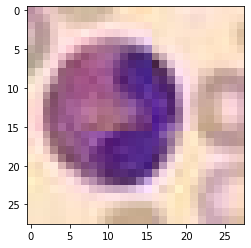

In [9]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

Data processing is applied to the dataset to auguement data when the size of the data set is small. The advantages of data augmentation are as follows:

  

*   It reduces the cost of collection of data.
*   It reduces data overfitting.
*   It creates variability and flexibility in data models.



In the model applied we implement horizontal flipping,vertical flipping, 
featurewise Pixel Normalization: scale pixel values to the range 0-1.
featurewise Pixel Centering: scale pixel values to have a zero mean.

featurewise here means per dataset

The fit function is then invoked to calculate the image statistics in the data generator function and store the value in memory
    


In [10]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True, 
                                    vertical_flip=True)

In [11]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.
The model choose for this exercise is a densely connected neural network. We inirailize the input layer by flatterning the 3 channel image to input all the features. Then we create a dense hidden network with 7 neurons and activation function Relu. Finally we create the output layer with activation functin softmax to classify labels. The model was created in such way to equate the number of parameters in the previous exercise. 

In [12]:
from keras import models
from keras import layers
# Define the input layer of the model with the size of an image.
model = models.Sequential([layers.Flatten(input_shape = train_x[0].shape),
# define a densely connected hiddden layer with 7 nodes and activation function relu
layers.Dense(7, activation = 'relu' ),                          
# Defines the output layer of the model a number of output nodes equal to the number of classes.
layers.Dense(len(np.unique(train_y)), activation = 'softmax' )])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 7)                 16471     
                                                                 
 dense_1 (Dense)             (None, 8)                 64        
                                                                 
Total params: 16,535
Trainable params: 16,535
Non-trainable params: 0
_________________________________________________________________


## Model Training
This is where we define the training options and then train the model.


*   Stochastic gradient descent is an iterative learning algorithm that uses a training dataset to update a model.

*   The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
*   The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.

*   learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.


*   Loss functions measure how far an estimated value is from its true value

*   Shuffle is set to false so that no shuffling of data takes places when augumenting data to preserve index









In [13]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [14]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE,shuffle=False), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE,shuffle=False),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)
#history = model.fit(train_x, to_categorical(train_y),batch_size = BATCH_SIZE,steps_per_epoch=len(train_x) / BATCH_SIZE,validation_data = (val_x, to_categorical(val_y)),epochs=NUM_EPOCHS,validation_steps=len(val_x) / BATCH_SIZE)

Epoch 1/10
186/186 [==============================] - 4s 11ms/step - loss: 1.9936 - accuracy: 0.2555 - val_loss: 1.9122 - val_accuracy: 0.3096
Epoch 2/10
186/186 [==============================] - 2s 10ms/step - loss: 1.8635 - accuracy: 0.3317 - val_loss: 1.8240 - val_accuracy: 0.3440
Epoch 3/10
186/186 [==============================] - 2s 10ms/step - loss: 1.7852 - accuracy: 0.3565 - val_loss: 1.7560 - val_accuracy: 0.3750
Epoch 4/10
186/186 [==============================] - 2s 10ms/step - loss: 1.7210 - accuracy: 0.3934 - val_loss: 1.7010 - val_accuracy: 0.4153
Epoch 5/10
186/186 [==============================] - 2s 9ms/step - loss: 1.6719 - accuracy: 0.4264 - val_loss: 1.6439 - val_accuracy: 0.4498
Epoch 6/10
186/186 [==============================] - 2s 10ms/step - loss: 1.6211 - accuracy: 0.4493 - val_loss: 1.6062 - val_accuracy: 0.4679
Epoch 7/10
186/186 [==============================] - 2s 10ms/step - loss: 1.5797 - accuracy: 0.4617 - val_loss: 1.5610 - val_accuracy: 0.4737


## Plot Learning Curves
This is where we visualise the training of the model.

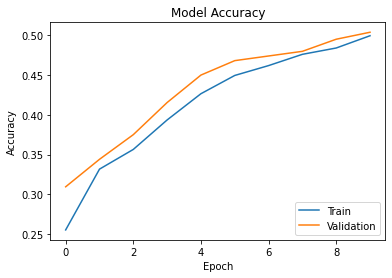

In [17]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

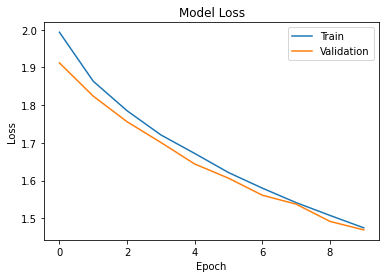

In [18]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate Data
We evaulate data using the model.evaluate function and passing the test data and the corresponding test labels. we use the model train to predict values based on test data and compare it to test lables to predict accuracy.

In [19]:
model.evaluate(data_generator.flow(test_x, to_categorical(test_y),batch_size=BATCH_SIZE,shuffle=False))

54/54 [==============================] - 0s 8ms/step - loss: 1.4772 - accuracy: 0.4961


[1.477217674255371, 0.4960537850856781]

In [20]:
# predict values using the augumented test data set
ypred=model.predict(data_generator.flow(test_x,batch_size=BATCH_SIZE,shuffle=False))
# convert probability distribution to index of the class
ypred1 = np.argmax(ypred, 1)
# convert to categorical
testy1=to_categorical(test_y,num_classes=8)
# identify the index of the class
testy2= np.argmax(testy1, 1)
print(classification_report(testy2, ypred1,target_names=targetnames))

                                                                     precision    recall  f1-score   support

                                                           basophil       0.08      0.00      0.01       244
                                                         eosinophil       0.38      0.74      0.50       624
                                                       erythroblast       0.48      0.72      0.57       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.30      0.12      0.18       579
                                                         lymphocyte       0.00      0.00      0.00       243
                                                           monocyte       0.21      0.05      0.08       284
                                                         neutrophil       0.49      0.69      0.57       666
                                                           platelet       0.96      0.96      0.96       470

                 

##Inference
In this exercise we classify an Multi-class(8) dataset with a Densely connected neural network. our model consist of an input layer which takes 28x28x3 as input ,A dense hidden layer with 7 neurons and finaly an output layer. The total number of trainable parameters is 16525. The proposed model has an accuracy of 49% with the augumented test dataset. This in line with the predicted values in the classification report. The testdataset is augumented because we need the test set to be similar to the training set due to image processing like standardization,centering,cropping etc. we can see from the two exercises that convolutionneural network has an accuracy of 68% compared to 49% for the densely connected NN. Some of the reasons for this are,



1.   CNN can extract more features for the similar amount of parameters. This allows for better prediction. For example Resnet-50 and and DeepNet201 have 25 and 20 million parameters and are 50 and 201 layers deeps.
2.   To match parameters the hidden layer has 7 neurons. From emipirical studies the hidden layer should have the values between input and output layer and if there is only one layer should have the mean of the two layers.

F1 score is a combined metric defined as product of precision*recall over the sum of precision and recall. Precision is defined as true positive over sum of true positive and false positive, Recall is definied as the true positive over sum of true positive and false negative. Precision can be seen as a measure of quality, and recall as a measure of quantity. Higher precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results. Our ideal value is getting a 1 on F1 score meaning 1 on both precision as well as recall.
From the classification report we can see that platelets has a score of 0.96 compared to 0.98 in CNN. basophil has the lowest F1 score and has a recal of 0.00 down from 0.17 which is terrible. we can see that the CNN network does a better job than the Dense connected layers. 

from these comparison we can conclude that 



1.   CNN are computationally efficient
2.   CNN can more accurately predict image classification than CNN for the same amount of parameters.



